In [1]:
import os, sys

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns
import json

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)
tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.set_visible_devices([physical_devices[0]], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')]


In [2]:
data_dir = './data'
historic_data_in_minibatch = 250
ema_lengths = [3, 5, 8, 9, 10, 13, 20, 21, 26, 34, 50, 55, 89, 100, 144, 200, 233, historic_data_in_minibatch]
len(ema_lengths)

18

# Description
This notebook is used for plotting simple metrics (confusion matrix, ROC curve, PRC curve) for already trained models. Just specify which model (directory name with 'trained_model' named model inside) you want to use in model_name variable below.

In case of using cryptocurrency model, please change scaler and datasets names for appropriate one.

In [3]:
model_name = 'przebieg_2021_06_05-13_41_25'

# Data loading

In [4]:
# Loading data from already prepared datasets
# In case of using cryptocurrency model, please change name of the imported datasets for proper one.
X_train, y_train = (
    np.load(os.path.join(data_dir, 'X_train_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_train_shuffled_with_mean_model.npz')))
X_train, y_train = X_train['arr_0'], y_train['arr_0']

X_valid, y_valid = (
    np.load(os.path.join(data_dir, 'X_valid_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_valid_shuffled_with_mean_model.npz')))
X_valid, y_valid = X_valid['arr_0'], y_valid['arr_0']

X_test, y_test = (
    np.load(os.path.join(data_dir, 'X_test_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_test_shuffled_with_mean_model.npz')))
X_test, y_test = X_test['arr_0'], y_test['arr_0']

In [5]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1])
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1])
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1])

## Data scaling

In [6]:
from pickle import dump, load

# In case of using model trained on crypto, use this scaler name: input_scaler_with_ema_shuffled_crypto.pkl
scaler: StandardScaler = load(open(f'./{model_name}/input_scaler_with_ema_shuffled.pkl', 'rb'))
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [7]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1], 1)
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1], 1)
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1], 1)

features_number = X_train.shape[1]

## Split for two model inputs

In [8]:
X_train_CNN, X_train_Dense = X_train[:, :historic_data_in_minibatch, :], X_train[:, historic_data_in_minibatch:, :] 
X_test_CNN, X_test_Dense = X_test[:, :historic_data_in_minibatch, :], X_test[:, historic_data_in_minibatch:, :] 
X_valid_CNN, X_valid_Dense = X_valid[:, :historic_data_in_minibatch, :], X_valid[:, historic_data_in_minibatch:, :] 

## y categorization

In [9]:
one_ids = np.where(y_train >= 0.9)
zero_ids = np.where(y_train < 0.9)

y_train[one_ids[0], one_ids[1]] = 1
y_train[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_train = y_train.astype(np.int)

Positive %: 0.04737364845037358
Negative %: 0.9526263515496264


In [10]:
one_ids = np.where(y_valid >= 0.9)
zero_ids = np.where(y_valid < 0.9)

y_valid[one_ids[0], one_ids[1]] = 1
y_valid[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_valid = y_valid.astype(np.int)

Positive %: 0.062239534739068236
Negative %: 0.9377604652609317


In [11]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.05826417435817886
Negative %: 0.9417358256418211


In [12]:
y_all = np.concatenate((y_train, y_valid, y_test))
temp = np.copy(y_all)
temp.shape

one_ids = np.where(temp >= 0.9)
zero_ids = np.where(temp < 0.9)

temp[one_ids[0], one_ids[1]] = 1
temp[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

unique, counts = np.unique(y_all, return_counts=True)
for val, qty in zip(unique, counts):
    print(f'Label {val}: {qty}')

Positive %: 0.05148319973085612
Negative %: 0.9485168002691439
Label 0: 603343
Label 1: 32748


In [13]:
neg, pos = np.unique(y_train, return_counts=True)[1]
total = neg + pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 10.55


# Load the model

In [14]:
model = tf.keras.models.load_model(f'./{model_name}/trained_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 1)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 1)       4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 256)     38656       batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 125, 256)     0           conv1d[0][0]                     
______________________________________________________________________________________________

In [15]:
model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)

2015/2015 [==============================] - 42s 21ms/step - loss: 0.3386 - tp: 560.0000 - fp: 980.0000 - tn: 59729.0000 - fn: 3196.0000 - binary_accuracy: 0.9352 - precision: 0.3636 - recall: 0.1491 - auc: 0.5665 - prc: 0.1218


{'loss': 0.33861997723579407,
 'tp': 560.0,
 'fp': 980.0,
 'tn': 59729.0,
 'fn': 3196.0,
 'binary_accuracy': 0.9352206587791443,
 'precision': 0.3636363744735718,
 'recall': 0.14909477531909943,
 'auc': 0.566476047039032,
 'prc': 0.121763214468956}

# Making predictions

In [16]:
y_pred = model.predict((X_test_CNN, X_test_Dense))
print(f'\n\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}\n')



Predicted min, max range: (7.185976e-27, 0.99995756)



In [17]:
_y_pred = np.copy(y_pred)
_pred_one = np.where(_y_pred >= 0.9)
_pred_zero = np.where(_y_pred < 0.9)

_y_pred[_pred_one] = 1.0
_y_pred[_pred_zero] = 0.0

In [18]:
y_train_pred = model.predict((X_train_CNN, X_train_Dense))
_y_train_pred = np.copy(y_train_pred)
_pred_one = np.where(_y_train_pred >= 0.9)
_pred_zero = np.where(_y_train_pred < 0.9)

_y_train_pred[_pred_one] = 1.0
_y_train_pred[_pred_zero] = 0.0

In [19]:
y_valid_pred = model.predict((X_valid_CNN, X_valid_Dense))
_y_valid_pred = np.copy(y_valid_pred)
_pred_one = np.where(_y_valid_pred >= 0.9)
_pred_zero = np.where(_y_valid_pred < 0.9)

_y_valid_pred[_pred_one] = 1.0
_y_valid_pred[_pred_zero] = 0.0

# Visualizations

## Confusion matrix

In [20]:
run_logdir = f'./{model_name}'

total: 64465
[[0.92653378 0.01520205]
 [0.04957729 0.00868688]]


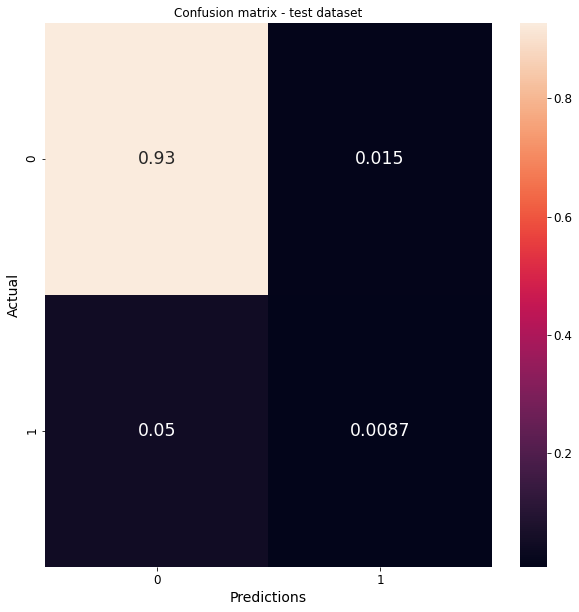

In [21]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_test, _y_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_test.svg')
plt.title('Confusion matrix - test dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 443010
[[0.94471005 0.0079163 ]
 [0.00638586 0.04098779]]


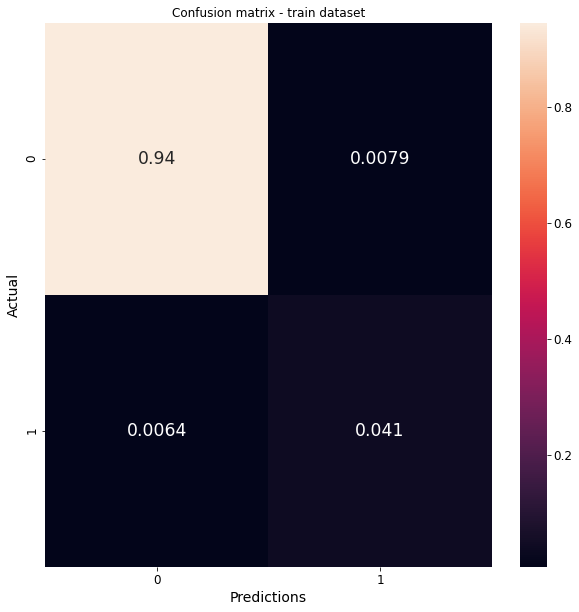

In [22]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_train, _y_train_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_train.svg')
plt.title('Confusion matrix - train dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 128616
[[0.89806867 0.0396918 ]
 [0.04162002 0.02061952]]


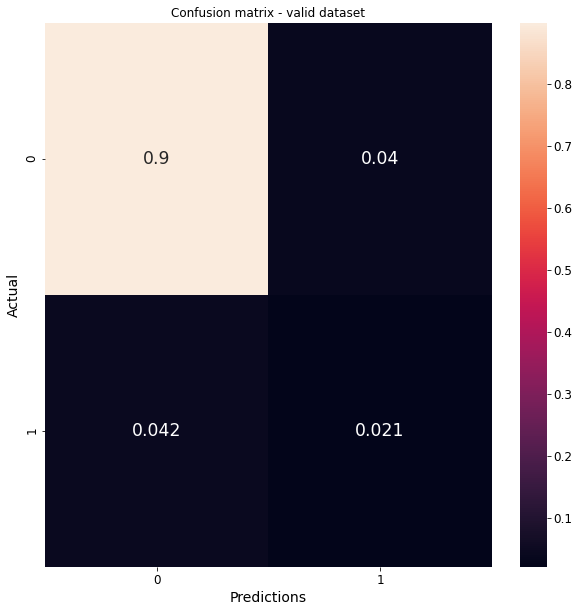

In [23]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_valid, _y_valid_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_valid.svg')
plt.title('Confusion matrix - valid dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

## ROC

In [24]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives rate (1-Specificity) [%]')
    plt.ylabel('True positives rate (Sensitivity) [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

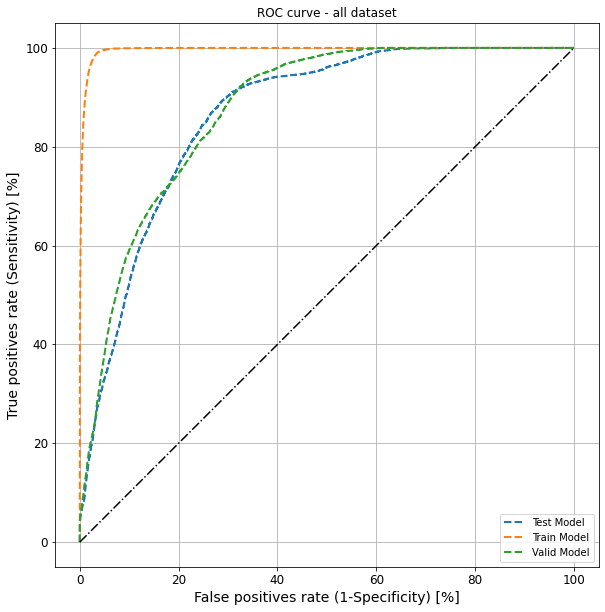

In [25]:
plt.figure(figsize=(10,10))
plot_roc("Test Model", y_test, y_pred, linestyle='--')
plot_roc("Train Model", y_train, y_train_pred, linestyle='--')
plot_roc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.plot([0, 100], [0, 100], '-.', c='black')
plt.legend(loc='lower right')
fname = os.path.join(run_logdir, 'roc_curve_all.svg')
plt.title('ROC curve - all dataset')
plt.savefig(fname, format='svg')
plt.show()

## PRC curve

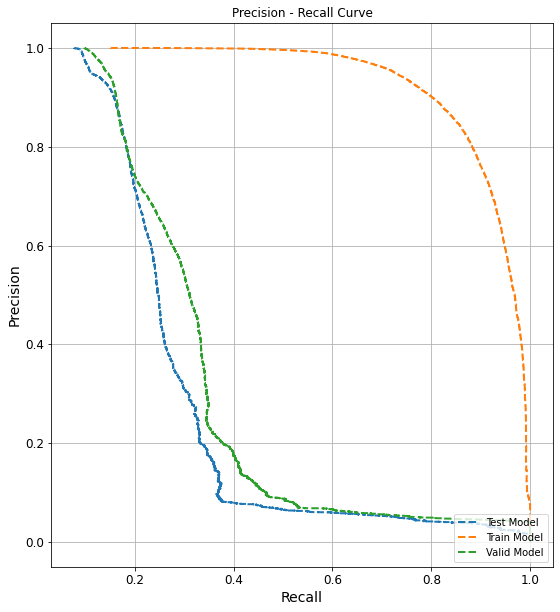

In [26]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

plt.figure(figsize=(10,10))
plot_prc("Test Model", y_test, y_pred, linestyle='--')
plot_prc("Train Model", y_train, y_train_pred, linestyle='--')
plot_prc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.legend(loc='lower right')
plt.title('Precision - Recall Curve')
fname = os.path.join(run_logdir, 'prc_curve.svg')
plt.savefig(fname, format='svg')
plt.show()